# Comparison of Station Data and HRDPS
Summer only, along strait in the JDF - along strait direction chosen based upon Ben's direction analysis

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import math
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt, colors
from windrose import WindroseAxes
from cmocean import cm as cmo
from tqdm.notebook import tqdm
from salishsea_tools import wind_tools, places, viz_tools
from scipy import interpolate

%matplotlib inline

In [2]:
#bring in data
racerocks = pd.read_csv("RaceRocks.csv").drop(['Temp (°C)','Stn Press (kPa)'],axis='columns')
sheringham = pd.read_csv("Sheringham.csv").drop(['Temp (°C)','Stn Press (kPa)'],axis='columns')
neah = pd.read_csv("neah.csv",header=0).drop(axis=0, index=0)

/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
neah['WDIR']=pd.to_numeric(neah['WDIR'])
neah['WSPD']=pd.to_numeric(neah['WSPD'])

## Station Distance into the Salish Sea
Based on Ben's analysis (https://nbviewer.jupyter.org/github/UBC-MOAD/PythonNotes/blob/master/windrecipes.ipynb) decide on each station's distance into the JDF so that you can convert wind to along-axis wind for each of them (direction not consistent throughout the JDF)

In [4]:
# Load HRDPS record
HRDPS = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/HRDPS_1h_20141201_20200201_wind.nc')

# Define coordinate variables
longitude, latitude = [HRDPS[var].values for var in ('longitude', 'latitude')]
deg2m, coslat = 111e3, np.cos(np.deg2rad(50))

# Limit HRDPS mask to open water
mask_trimmed = np.copy(HRDPS.landmask.values)
mask_trimmed[20:40, 40:50] = 0 # Saanich Inlet
mask_trimmed[:, 72:] = 0       # Boundary Bay
mask_trimmed[40:, 61:] = 0     # Fraser River
mask_trimmed[58:, 53:] = 0     # Howe Sound
mask_trimmed[76:, 35:] = 0     # Jervis Inlet
mask_trimmed[100:, :] = 0      # Discovery Islands

# Define along-axis guides (x, y)
guides = {
    'west': [(2, 40), (40, 15), (45, 20), (45, 35), (18, 60), (0, 97)],
    'east': [(0, 15), (40, 0), (73, 0), (73, 45), (45, 75), (18, 106)],
}

In [5]:
# Find lon and lat at the midpoint of each cross-axis segment
lons, lats, midpoints = [], [], []
for segment in zip(*guides.values()):
    xy = [[xy[dim] for xy in segment] for dim in (0, 1)]
    midpoint = tuple(int((coord[1] - coord[0]) / 2 + coord[0]) for coord in xy)
    lon, lat = [coord[midpoint[::-1]] for coord in (longitude, latitude)]
    lons.append(lon), lats.append(lat), midpoints.append(midpoint)
#     ax.plot(*xy, 'b--')
#     ax.plot(*midpoint, 'bo')

# Define along-axis distance on the midpoints according to the lon and lat differences
distance = np.sqrt((np.diff(lons) * deg2m * coslat)**2 + (np.diff(lats) * deg2m)**2)
distance = list(np.insert(np.cumsum(distance), 0, 0))
    
st_lat = [lats[0], 48.493, 48.281147, 48.23] #had to mess with the latitudes a bit to get the point in the middle of the strait
# st_lat = [lats[0], 48.493, sheringham["Latitude (y)"][0], racerocks["Latitude (y)"][0]]
st_lon = [lons[0], -124.726, sheringham["Longitude (x)"][0], racerocks["Longitude (x)"][0]]

st_distance = np.sqrt((np.diff(st_lon) * deg2m * coslat)**2 + (np.diff(st_lat) * deg2m)**2)
st_distance = list(np.insert(np.cumsum(st_distance), 0, 0))
st_distance

[0.0, 13922.698385907512, 76052.52679718049, 104452.06100786847]

In [6]:
# Interpolate distances onto HRDPS grid
guidepoints = [[], []]
for dim in (0, 1):
    for cst in guides:
        guidepoints[dim].extend([xy[dim] for xy in guides[cst]])
xi = tuple(np.meshgrid(*[np.arange(len(HRDPS[dim])) for dim in ('gridX', 'gridY')]))
distance_interp = interpolate.griddata(tuple(guidepoints), distance + distance, xi)

In [7]:
# Process wind
mask_flat = mask_trimmed.reshape(-1).astype('bool')
u, v = [HRDPS[var].values for var in ['u_wind', 'v_wind']]
dist = np.broadcast_to(distance_interp, u.shape)
dist, u, v = [var.reshape(-1, len(mask_flat))[:, mask_flat].flatten() for var in (dist, u, v)]
wspd = np.sqrt(u**2 + v**2)
wdir = np.rad2deg(np.arctan2(v, u)) - 90   # CCW from N
wdir[wdir < 0] = wdir[wdir < 0] + 360      # shift to 0-360

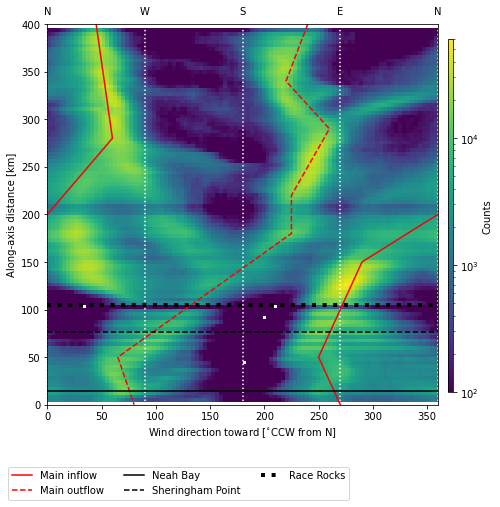

In [10]:
# Make plot area
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot wind direction vs along-axis distance, for wind speed > 5 m/s
_, _, _, c = ax.hist2d(wdir[wspd>5], 1e-3*dist[wspd>5], bins=100, norm=colors.LogNorm(vmin=1e2, vmax=6e4))

# Add grid lines
for x, label in zip(np.arange(0, 361, 90), ['N', 'W', 'S', 'E', 'N']):
    ax.plot([x, x], [0, 400], 'w:')
    ax.text(x, 410, label, ha='center')

# Trace dominant flow patterns
ax.plot([45, 60, 0, np.nan, 360, 290, 250, 270], [400, 280, 200, np.nan, 200, 150, 50, 0], 'r-', label='Main inflow')
ax.plot([240, 220, 260, 225, 225, 65, 80], [400, 340, 290, 220, 180, 50, 0], 'r--', label='Main outflow')
ax.plot([0, 360], [st_distance[1]/1000,st_distance[1]/1000], 'k-', label='Neah Bay')
ax.plot([0, 360], [st_distance[2]/1000,st_distance[2]/1000], 'k--', label='Sheringham Point')
ax.plot([0, 360], [st_distance[3]/1000,st_distance[3]/1000], 'k:', label='Race Rocks', linewidth='4')

# Formatting
lims = [(0, 360, 0, 150)]
ticks = [(0, 361, 45, 0, 150, 50)]

ax.set_xlim(0,360)
ax.set_ylim(0,400)

# ax.xaxis.set_ticks(np.arange(*tick[:3]))
# ax.yaxis.set_ticks(np.arange(*tick[3:]))

ax.set_xlabel('Wind direction toward [$^{\circ}$CCW from N]')
ax.set_ylabel('Along-axis distance [km]')
ax.legend(loc=(-0.1, -0.25), ncol=3)
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax, label='Counts')

## Convert wind to along strait speed
Decide on 'along strait' wind direction for each station and convert their speeds using this value to along striat wind speed

In [11]:
#setting 'in' as the positive direction
direc_nb = 265
direc_sh = 270
direc_rr = 290
#race-rocks dominant direction not as clear

In [12]:
def along_axis_wind(speed,direc,axis_angle):
    a = axis_angle - 270
    s_out = 0
    
    direc += a
    if direc > 360:
        direc -= 360
    
    if direc>=0 and direc<90:
        b = math.radians(90-direc)
        s_out = -math.cos(b)*speed
    elif direc>=90 and direc<180:
        b = math.radians(direc-90)
        s_out = -math.cos(b)*speed
    elif direc>=180 and direc<270:
        b = math.radians(270-direc)
        s_out = math.cos(b)*speed
    else:
        b = math.radians(direc-270)
        s_out = math.cos(b)*speed
    
    return s_out

In [13]:
s_neah = np.zeros(len(neah))

for i in range(len(neah)):
    s_neah[i] = along_axis_wind(neah.WSPD[i+1],neah.WDIR[i+1],direc_nb)

neah['axisSPD'] = s_neah

In [14]:
s_sh = np.zeros(len(sheringham))

for i in range(len(sheringham)):
    s_sh[i] = along_axis_wind(sheringham['Wind Spd (km/h)'][i],sheringham['Wind Dir (10s deg)'][i]*10,direc_sh)

sheringham['axisSPD'] = s_sh

In [15]:
s_rr = np.zeros(len(racerocks))

for i in range(len(racerocks)):
    s_rr[i] = along_axis_wind(racerocks['Wind Spd (km/h)'][i],racerocks['Wind Dir (10s deg)'][i]*10,direc_rr)

racerocks['axisSPD'] = s_rr